In [35]:
import pandas as pd
import shapely.wkt
from pyproj import Geod
from shapely import wkt
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
parcel_pairs_df = pd.read_csv("sampledataset.csv")

In [20]:
parcel_pairs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      513 non-null    int64 
 1   Pair_a  513 non-null    object
 2   Pair_b  513 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.1+ KB


In [3]:
parcel_pairs_df.describe(include="all")

,id,Pair_a,Pair_b
count,513.000000,513,513
unique,NaN,239,235
top,NaN,"POLYGON ((31.5180459009 1.6125885638, 31.51804...","POLYGON ((31.4562504180292 1.63284358914328, 3..."
freq,NaN,15,15
mean,262.881092,NaN,NaN
std,151.792787,NaN,NaN
min,0.000000,NaN,NaN
25%,130.000000,NaN,NaN
50%,266.000000,NaN,NaN
75%,394.000000,NaN,NaN


In [114]:
# parcel_set1 = (set(parcel_pairs_df['Pair_a'] + parcel_pairs_df['Pair_b']))
parcels = set()
for p in parcel_pairs_df['Pair_a']:
    parcels.add(str(p))
for p in parcel_pairs_df['Pair_b']:
    parcels.add(str(p))
parcel_list = list(parcels)    
print(f"Unique parcels in the list : {len(parcel_list)}")
indexes = np.arange(0, len(parcel_list))

Unique parcels in the list : 278


In [169]:
type(parcel_pairs_df['Pair_a'][0])

str

In [170]:

parcels_df = pd.DataFrame(columns=['parcelId', 'area (m^2)', 'perimeter (m)', 'numConflicts','avgOverlapArea (m^2)'], index=indexes)
augmented_parcel_pairs_df = pd.DataFrame(columns=["pairId", "parcel1Id", "parcel2Id", "Area1 in m^2", "Area2 in m^2", "IntersectionArea in m^2", "OverlapToSumRatio", "OverlapToSmallRatio"])

In [171]:
augmented_parcel_pairs_df

,pairId,parcel1Id,parcel2Id,Area1 in m^2,Area2 in m^2,IntersectionArea in m^2,OverlapToSumRatio,OverlapToSmallRatio


In [172]:
#https://pyproj4.github.io/pyproj/stable/api/geod.html#pyproj.Geod.geometry_area_perimeter 
#https://stackoverflow.com/questions/23697374/calculate-polygon-area-in-planar-units-e-g-square-meters-in-shapely
# Calculate a geodesic area, which is very accurate and only requires an ellipsoid (not a projection). This can be done with pyproj 2.3.0 or later.

from collections import defaultdict

overlaps = defaultdict(list)

# specify a named ellipsoid
geod = Geod(ellps="WGS84")

total_area = 0
total_intersection = 0
for (index, row) in parcel_pairs_df.iterrows():
    p1 = row['Pair_a']
    id_parcel_1 = parcel_list.index(str(p1))
    p1 = shapely.wkt.loads(p1)
    p2 = row['Pair_b']
    id_parcel_2 = parcel_list.index(str(p2))
    p2 = shapely.wkt.loads(p2)

    #This way of calculating area wouldn't give area in m^2
    #     a1 = round(p1.area,8)
    #     a2 = round(p2.area,8)
    area1, peri1 = geod.geometry_area_perimeter(p1)
    area2, peri2 = geod.geometry_area_perimeter(p2)

    #Values can be negative depending on clockwise vs anti

    area1 = abs(area1)
    area2 = abs(area2)
    peri1 = abs(peri1)
    peri2 = abs(peri2)
    total_area += area1 + area2

    intersection = p1.intersection(p2)
    area_intersection, poly_intersection = geod.geometry_area_perimeter(intersection)
    area_intersection = abs(area_intersection)
    ai = round(area_intersection, 5)

    total_intersection += round(area_intersection, 5)

    if area1 == 0 or area2 == 0:
        print(f"{index} {id_parcel_1}, {id_parcel_2} Found an area with zero m^2!")

    if area1 < area2:
        perc_intersection = ai/area1
    else:
        perc_intersection = ai/area2
    
    intersection_total_ratio = round(ai/(area1+area2), 6)
    perc_intersection = round(perc_intersection, 6)
#     print(f"{index} {id_parcel_1} {id_parcel_2} {area1} {area2} {perc_intersection}")
    augmented_parcel_pairs_df = augmented_parcel_pairs_df.append({"pairId":row['id'],"parcel1Id":id_parcel_1, "parcel2Id":id_parcel_2, "Area1 in m^2":area1, "Area2 in m^2":area2, "IntersectionArea in m^2":ai, "OverlapToSumRatio":intersection_total_ratio, "OverlapToSmallRatio":perc_intersection}, ignore_index=True) 
    parcels_df.loc[id_parcel_1] = [id_parcel_1, area1, peri1, 0, 0]
    parcels_df.loc[id_parcel_2] = [id_parcel_2, area2, peri2, 0, 0]
#     parcels_df = parcels_df.append({'parcelId': id_parcel_1, 'area (m^2)':area1, 'parameter (m)':peri1}, ignore_index=True)
#     parcels_df = parcels_df.append({'parcelId': id_parcel_2, 'area (m^2)':area2, 'parameter (m)':peri2}, ignore_index=True)
    #If there is an intersection, we will add it to a list of all the parcels it conflicts with
    if ai > 0:
        overlaps[id_parcel_1].append((id_parcel_2, ai))
        overlaps[id_parcel_2].append((id_parcel_1, ai))

        

for i, conflicts in overlaps.items():
    total_count = len(conflicts)
    total_area_int = sum(list(list(zip(*conflicts))[1]))
    avg_area_int = total_area_int/total_count
    parcels_df.loc[i,"numConflicts"] = total_count
    parcels_df.loc[i,"avgOverlapArea (m^2)"] = avg_area_int

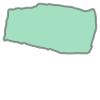

In [200]:
p1

In [173]:
parcels_df = parcels_df.astype({'area (m^2)': 'float64','avgOverlapArea (m^2)': 'float64'})
parcels_df.describe()

,area (m^2),avgOverlapArea (m^2)
count,2.780000e+02,278.000000
mean,1.889782e+05,4550.132618
std,3.020809e+06,5200.461885
min,3.841093e+00,0.352880
25%,4.052138e+03,660.070600
50%,6.385859e+03,3486.563510
75%,1.027604e+04,6542.829668
max,5.037463e+07,56713.738090


In [189]:
parcels_df.sort_values(by=["numConflicts","avgOverlapArea (m^2)"] , ascending=False)

,parcelId,area (m^2),perimeter (m),numConflicts,avgOverlapArea (m^2)
10,10,20999.522319,658.81729,30,20999.52232
58,58,7515.713307,347.814299,30,7515.71331
176,176,6686.182581,368.224931,30,6686.18258
262,262,3281.880258,242.682452,30,3281.88026
91,91,1942.537778,216.332589,20,1942.53778
...,...,...,...,...,...
18,18,11968.637718,455.659548,1,5.18599
241,241,6350.750006,322.739995,1,5.18599
12,12,5.018868,8.022547,1,1.21831
68,68,13626.622736,695.22049,1,0.35288


In [182]:
overlaps[110]

[(257, 0.89996),
 (257, 0.89996),
 (156, 843.05994),
 (156, 843.05994),
 (110, 6711.15753),
 (110, 6711.15753),
 (257, 0.89996),
 (257, 0.89996),
 (156, 843.05994),
 (156, 843.05994)]

In [192]:
augmented_parcel_pairs_df = augmented_parcel_pairs_df.astype({'pairId': 'int32','parcel1Id': 'int32', 'parcel2Id': 'int32'})
augmented_parcel_pairs_df.sort_values(by="IntersectionArea in m^2", ascending=True).head(40)


,pairId,parcel1Id,parcel2Id,Area1 in m^2,Area2 in m^2,IntersectionArea in m^2,OverlapToSumRatio,OverlapToSmallRatio
167,171,56,123,4229.161343,3709.418362,0.14280,0.000018,0.000038
164,168,68,112,13626.622736,8794.863453,0.35288,0.000016,0.000040
318,328,110,257,6711.157529,4972.138188,0.89996,0.000077,0.000181
326,336,257,110,4972.138188,6711.157529,0.89996,0.000077,0.000181
47,47,12,208,5.018868,158.641939,1.21831,0.007444,0.242746
118,120,151,167,8445.536929,12952.190388,2.28441,0.000107,0.000270
471,481,240,50,14418.623470,10212.399572,2.70806,0.000110,0.000265
290,300,204,177,1891.184846,4446.700577,3.68439,0.000581,0.001948
37,37,36,36,3.841093,3.841093,3.84109,0.500000,0.999999
205,215,47,168,9780.060237,11555.703132,4.40631,0.000207,0.000451


In [179]:
augmented_parcel_pairs_df.drop_duplicates(subset=["parcel1Id", "parcel2Id", "Area1 in m^2", "Area2 in m^2", "IntersectionArea in m^2", "OverlapToSumRatio", "OverlapToSmallRatio"],inplace=True)
augmented_parcel_pairs_df[augmented_parcel_pairs_df["parcel1Id"]==10]

,pairId,parcel1Id,parcel2Id,Area1 in m^2,Area2 in m^2,IntersectionArea in m^2,OverlapToSumRatio,OverlapToSmallRatio
25,25,10,10,20999.522319,20999.522319,20999.52232,0.5,1.0


<AxesSubplot:ylabel='Frequency'>

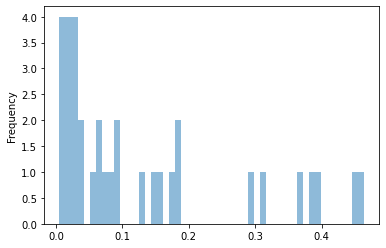

In [198]:
mid_df['OverlapToSumRatio'].plot.hist(bins=50, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

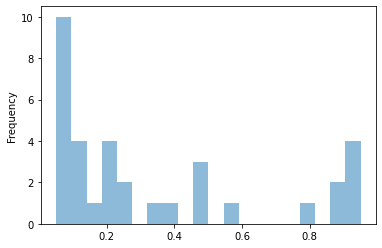

In [199]:
mid_df['OverlapToSmallRatio'].plot.hist(bins=20, alpha=0.5)

In [197]:
mid_df = augmented_parcel_pairs_df[(augmented_parcel_pairs_df["OverlapToSmallRatio"] < .95) & (augmented_parcel_pairs_df["OverlapToSmallRatio"] > 0.05)]
mid_df

,pairId,parcel1Id,parcel2Id,Area1 in m^2,Area2 in m^2,IntersectionArea in m^2,OverlapToSumRatio,OverlapToSmallRatio
0,0,174,52,10460.257643,6551.586060,333.14170,0.019583,0.050849
20,20,27,225,6678.047739,6933.044870,6305.99952,0.463299,0.944288
22,22,195,175,18943.340563,36830.001323,17203.10262,0.308447,0.908135
40,40,105,217,3285.671783,3672.716664,3120.32622,0.448427,0.949677
41,41,143,55,102.513528,138.999379,92.09048,0.381307,0.898325
42,42,143,251,102.513528,166.526794,7.44023,0.027655,0.072578
43,43,143,208,102.513528,158.641939,48.88030,0.187169,0.476818
44,44,143,133,102.513528,166.503135,48.66224,0.180889,0.474691
47,47,12,208,5.018868,158.641939,1.21831,0.007444,0.242746
48,48,55,251,138.999379,166.526794,26.01511,0.085149,0.187160


# purposely not excluding the above since this data is given to identify degrees of overlap and 

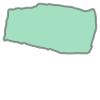

In [70]:
p1

In [26]:
print(p2.area)

1.1275136459520801e-06


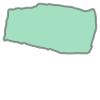

In [14]:
p1.intersection(p2)

## Looks like the calculated area is in square degree

In [6]:
len(unique_polygons)

276

In [7]:
total_area

0.021149410000000014

In [8]:
total_intersection

0.00020357999999999986

In [9]:
total_intersection*100/total_area

0.962580043604052

In [ ]:
type(p1)

shapely.geometry.polygon.Polygon

In [11]:
!pip install mpl_toolkits

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


(13205034.646911621, 17286.088115295493)
# Geodesic area: 13205034.647 m^2


In [10]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

#Coordinates that are to be transformed
long = -112.367
lat = 41.013

#Create a basemap for your projection. Which one you use is up to you.
#Some examples can be found at http://matplotlib.org/basemap/users/mapsetup.html
m = Basemap(projection='sinu',lon_0=0,resolution='c')

#Project the coordinates:
projected_coordinates = m(long,lat)

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [202]:
!pip install osmx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 995.2/995.2 kB 8.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.4/531.4 kB 9.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lmdb: filename=lmdb-0.99-cp39-cp39-macosx_10_9_x86_64.whl size=94138 sha256=99c1c17f7e5a24a3f90d8599cbd85b7b8b5f5b8cb6a9b158e545fa025b72ca69
  Stored in directory: /Users/mrinalgrover/Library/Caches/pip/wheels/eb/d3/07/76f73475af803e5cc1fc1053aac7c3b432d4c06c37c5bbc41b
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [372 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-39
      creating build/lib.macosx-10.9-x86_64-cpython-39/capnp
      copying capnp/version.py -> build/lib.macosx-10.9-x86_64-cpython-39/capnp
      copying cap

In [201]:
import osmnx as ox

vancouver = ox.geocode_to_gdf("Vancouver, Canada")
vancouver.plot(edgecolor="0.2")
plt.title("Vancouver");

ModuleNotFoundError: No module named 'osmnx'